In [1]:
# %pip install nltk==3.8.1
# %pip install unidecode==1.3.8
# %pip install scikit-learn==1.2.2
# %pip install pandas==2.0.3
# %pip install wordcloud==1.9.3

In [2]:
import datetime
import math
import pickle
import re
import string
import sys
import warnings

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from unidecode import unidecode
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download("stopwords")

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jean_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jean_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocessa_texto(texto):
    padrao = r"\w+(?:'\w+)?|[^\w\s]"
    tokens_preprocessados = re.findall(padrao, texto)

    tokens_preprocessados = [token.lower() for token in tokens_preprocessados]

    portugues_stops = stopwords.words("portuguese")

    tokens_preprocessados = [
        token for token in tokens_preprocessados if token not in portugues_stops
    ]

    tokens_preprocessados = [
        re.sub(r"\d+", "", token) for token in tokens_preprocessados
    ]

    tokens_preprocessados = [
        token for token in tokens_preprocessados if token not in string.punctuation
    ]

    tokens_preprocessados = [unidecode(token) for token in tokens_preprocessados]

    return " ".join(tokens_preprocessados)

In [4]:
URL = "https://raw.githubusercontent.com/gomesluiz/commonlit-readability-predicting/main/datasets/train.csv"

trechos = pd.read_csv(URL, usecols=("excerpt", "target"))

trechos.columns = ["trecho", "legibilidade"]

trechos["legibilidade"].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: legibilidade, dtype: float64

In [5]:
legibilidade_categoria = [
    "Muito Dificil",
    "Dificil",
    "Moderado",
    "Padrão",
    "Bastante Facil",
    "Facil",
]
trechos["legibilidade_categoria"] = pd.cut(
    trechos["legibilidade"],
    bins=[-4.00, -3.00, -2.00, -1.00, 0.00, 1.00, 2.00],
    labels=legibilidade_categoria,
)

trechos.head(10)

,trecho,legibilidade,legibilidade_categoria
0,When the young people returned to the ballroom...,-0.340259,Padrão
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão
3,And outside before the palace a great garden w...,-1.054013,Moderado
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil
5,Hal and Chester found ample time to take an in...,-0.861809,Padrão
6,Hal Paine and Chester Crawford were typical Am...,-1.759061,Moderado
7,"On the twenty-second of February, 1916, an aut...",-0.952325,Padrão
8,The boys left the capitol and made their way d...,-0.371641,Padrão
9,One day he had gone beyond any point which he ...,-1.238432,Moderado


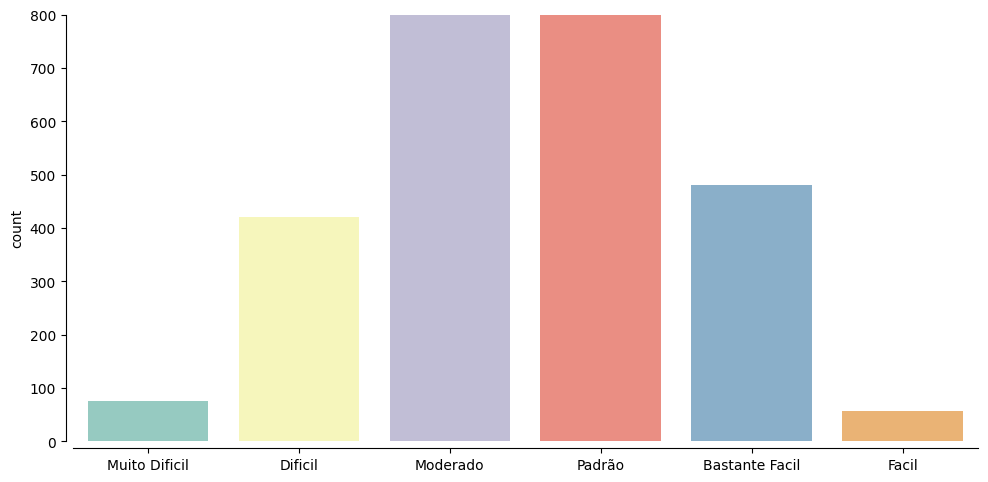

In [6]:
g = sns.catplot(
    data=trechos,
    x="legibilidade_categoria",
    height=5,
    aspect=2,
    kind="count",
    palette="Set3",
    legend=False,
)

sns.despine(offset=5)

g.set(ylim=(0, 800))
g.set(xlabel=None)

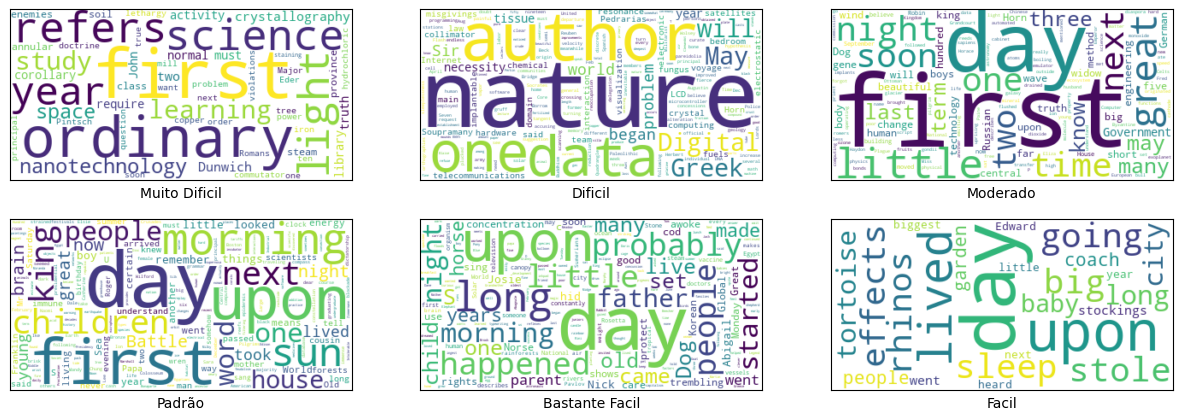

In [7]:
linhas, colunas = 2, 3
conta_linha, conta_coluna = 0, 0
fig, ax = plt.subplots(linhas, colunas, sharex="col", sharey="row", figsize=(15, 5))

for categoria in legibilidade_categoria:
    textos = trechos[(trechos.legibilidade_categoria == categoria)].trecho
    words = " ".join([texto.split()[1] for texto in textos])

    word_cloud = WordCloud(collocations=False, background_color="white").generate(words)
    ax[conta_linha, conta_coluna].imshow(word_cloud, interpolation="bilinear")
    ax[conta_linha, conta_coluna].set_xticks(())
    ax[conta_linha, conta_coluna].set_yticks(())
    ax[conta_linha, conta_coluna].set(xlabel=categoria)

    conta_coluna += 1
    if conta_coluna > 2:
        conta_linha = conta_linha + 1
        conta_coluna = 0

In [8]:
trechos["trecho_preprocessados"] = trechos["trecho"].apply(preprocessa_texto)
trechos.head()

,trecho,legibilidade,legibilidade_categoria,trecho_preprocessados
0,When the young people returned to the ballroom...,-0.340259,Padrão,when the young people returned to the ballroom...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,Padrão,all through dinner time mrs fayre was somewhat...
2,"As Roger had predicted, the snow departed as q...",-0.580118,Padrão,roger had predicted the snow departed quickly ...
3,And outside before the palace a great garden w...,-1.054013,Moderado,and outside before the palace great garden was...
4,Once upon a time there were Three Bears who li...,0.247197,Bastante Facil,once upon time there were three bears who live...


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    trechos["trecho_preprocessados"],
    trechos["legibilidade_categoria"],
    test_size=.25,
    random_state=32,
)

In [10]:
vetorizador = CountVectorizer(max_features=1000)
X_train_vetorizado = vetorizador.fit_transform(X_train)
X_train_vetorizado = pd.DataFrame(
    X_train_vetorizado.toarray(), columns=vetorizador.get_feature_names_out()
)
X_train_vetorizado.index = X_train_vetorizado.index
X_train_vetorizado.head()

,ability,able,about,above,according,account,across,act,action,activity,...,written,wrong,year,years,yellow,yes,yet,you,young,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_test_vetorizado = vetorizador.transform(X_test)
X_test_vetorizado = pd.DataFrame(
    X_test_vetorizado.toarray(), columns=vetorizador.get_feature_names_out()
)
X_test_vetorizado.index = X_test_vetorizado.index
X_test_vetorizado.head()

,ability,able,about,above,according,account,across,act,action,activity,...,written,wrong,year,years,yellow,yes,yet,you,young,your
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [12]:
clf = MultinomialNB()
_=clf.fit(X_train_vetorizado,Y_train)

In [13]:
y_pred = clf.predict(X_test_vetorizado)

In [14]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred))

                precision    recall  f1-score   support

Bastante Facil       0.39      0.52      0.45       103
       Dificil       0.42      0.58      0.49       116
         Facil       0.11      0.06      0.08        17
      Moderado       0.43      0.34      0.38       204
 Muito Dificil       0.08      0.31      0.12        13
        Padrão       0.48      0.34      0.40       256

      accuracy                           0.40       709
     macro avg       0.32      0.36      0.32       709
  weighted avg       0.42      0.40      0.40       709



In [15]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-#S")
arquivo = f"{timestamp}-modelo-predicao-legibilidade.sav"
pickle.dump(clf, open(arquivo, "wb"))